# ML Modeling: Business Closure Prediction
Objective: Train a Machine Learning (ML) model to predict whether an Yelp business will close:
- Problem: **Binary Classification** Predict whether the Yelp business is labeled as _open_ or _closed_.
- Evaluation Metric: F1-Score,
- Dataset: [Yelp Dataset](https://www.yelp.com/dataset)

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from typing import Generic
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression

sns.set_theme()

# Prepare Dataset

### Load Dataset
Load prepared Yelp Dataset

In [2]:
reviews_df = pd.read_parquet("https://ntu-sc1015-yelp.s3.ap-southeast-1.amazonaws.com/yelp_reviews.parquet/part-00000-tid-666118639932506010-9f727aa9-11e6-466d-9314-69664704543d-2119-1-c000.snappy.parquet")

### Regroup Data
Cardinality of `reviews_df` is at the _reviews level_. We are specfically interested in business features at the _business level_.

Regroup data to the _business level_ and extract business features:


In [3]:
business_cols = reviews_df.columns[reviews_df.columns.str.startswith("business_")]
business_df = reviews_df[business_cols].groupby("business_id").first()

### Target Variable
Given Yelp dataset features, we are trying to whether `business_is_open`:
- `0` This business has **closed**
- `1` This business is still **open**.


In [4]:
target = "business_is_open"
targets = business_df[target]
features = business_df.columns[business_df.columns != target]
feature_df = business_df[features]

### Split Dataset
Split dataset into train and test subsets using stratified random sampling to ensure consistent target distribution on train / test subsets.

In [5]:
train_feature_df, test_feature_df, train_targets, test_targets = train_test_split(
    feature_df, targets, test_size=0.2, random_state=42, stratify=targets)

### Transform for ML
Apply transformations to data to convert it into a form suitable for Machine Learning.

#### Target: Business Is Open
Observed that our target `business_is_open` is heavily skewed towards open (1)
businesses.


<Axes: title={'center': 'business_is_open'}>

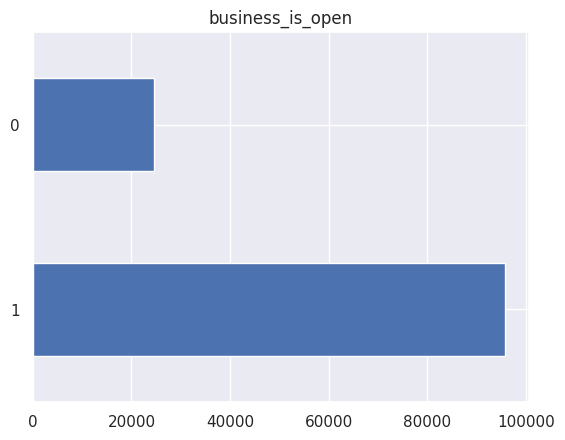

In [23]:
plt.title("business_is_open")
train_targets.value_counts().plot(kind="barh")

Correct for the class imbalance by randomly **undersampling** the majority class
to match no. of samples in the minority class.


In [27]:
sampler = RandomUnderSampler(sampling_strategy="majority", random_state=42)

#### Business Rating
`business_stars`
- In Exploratory Data Analysis (EDA), we have observed that `business_stars` is right skewed, hence `np.exp2()` is applied to correct the skew.
- `StandardScaler` is applied to normalise feature values to a range suitable for ML models.

In [58]:
transform = ColumnTransformer(
  transformers=[
    ("business_stars", Pipeline(steps=[
         ("unskew_exp2", FunctionTransformer(np.exp2)),
         ("scale", StandardScaler()),
    ]), ["business_stars"])
  ]
)

# ML Modelling



### ML Algorithms
Models will be built from the following ML Algorithms:

In [59]:
models = [
  LogisticRegression()
]

### Model Evaluation
Model evaluation be performed on the following metrics:
- F1-score: Harmonic Mean of Precision and Recall
- Precision
- Recall
- Accuracy

Do to the presence of class imbalance, F1-score is choosen over Accuracy as the _core metric_ to benchmark Models for Model Selection.

In [60]:
metrics = [
  "f1",
  "precision",
  "recall",
  "accuracy",
]

### Train & Evaluation Lifecycle
Group data transformation, model training & evaluation steps into a single objective function:


In [61]:
def train_eval(model: BaseEstimator, feature_df: pd.DataFrame, targets: pd.Series) -> pd.DataFrame:
  # group data transform & model steps in single pipeline
  pipeline = Pipeline(
    steps=[
      ("sample_data", sampler),
      ("transform_data", transform),
      ("model", model),
    ]
  )

  # train & evaluate model with metrics
  results = cross_validate(
      estimator=pipeline,
      X=feature_df,
      y=targets,
      scoring=metrics,
      cv=5,
      return_train_score=True,
      # cross validate on all CPU cores
      n_jobs=-1,
  )
  return pd.DataFrame(results)

In [62]:
train_eval(models[0], train_feature_df[-10:], train_targets[-10:])

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


,fit_time,score_time,test_f1,train_f1,test_precision,train_precision,test_recall,train_recall,test_accuracy,train_accuracy
0,0.040279,0.016568,0.000000,0.6,0.0,0.750000,0.0,0.5,0.5,0.5
1,0.036106,0.014802,0.666667,0.6,0.5,0.750000,1.0,0.5,0.5,0.5
2,0.019676,0.014651,0.000000,0.6,0.0,0.750000,0.0,0.5,0.5,0.5
3,0.018522,0.014292,0.666667,0.5,1.0,0.666667,0.5,0.4,0.5,0.5
4,0.012897,0.009539,0.666667,0.5,1.0,0.666667,0.5,0.4,0.5,0.5
